# War of the Words: Human vs AI Essay Challenge
<img src="https://mikewlange.github.io/ai-or-human/images/ai_or_human_overview.png" alt="Alt Text" >

# Introduction 

&#10132; This notebook explores the capability of machine learning algorithms to distinguish between essays written by humans and those generated by AI models. 

> <span style="display: inline-block;padding: 5px;background-color: #f4f3ee;margin-bottom: 5px;line-height: 1.5;color: #333;" class="tip"> <b>Merlin's Beard! </b>Anytime you pass "automated judgment" on a human, and this IS that, it's not a bad idea to do so in a thoughtful and transparent way. </span>


**Competition:** https://www.kaggle.com/competitions/llm-detect-ai-generated-text

"*Can you help build a model to identify which essay was written by middle and high school students, and which was written using a large language model?*"

**Perhaps..**

# Notebooks

Data: 
- https://www.kaggle.com/datasets/geraltrivia/llm-detect-gpt354-generated-and-rewritten-essays
- https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset 

Models: 
- https://www.kaggle.com/code/geraltrivia/ai-human-pytorchbertsequenceclassifier-model
- https://www.kaggle.com/code/geraltrivia/ai-human-pytorchcustombertclassifier-model

- Main Notebook: https://www.kaggle.com/code/geraltrivia/ai-human-pytorchbert-2-ebm

note: these are the two models in this notebook. Had to train in another, it's too expensive to run all at once.

Notebooks: This code and the ClearML pipelines including the Essay Generation are here https://github.com/mikewlange/ai-or-human. 

# Setup for offline Run. 

It's possible I'm doing this all wrong. But to submit to a contest that disables the internet you neeed to add pypy packages and other code/models that are not installed in the Kagle docker image https://github.com/Kaggle/docker-python, into a Dataset (I.E sotrage) and use that as iinput to your notebook.

In [1]:
# turn off he internet and doing your pip installs, the packages you can't install, add to the libray var below 

# TURN ON INTERNET FOR THIS
# creates a wheelhouse to add 
# 
# library = \
# '''
# textstat
# clearml
# sentence_transformers
# optuna
# interpret
# torchsummary
# empath
# benepar
# '''.lstrip('\n')
# with open('requirements.txt', 'w+') as f:
#     f.write(library)
    
#!mkdir wheelhouse && pip download -r requirements.txt -d wheelhouse

# # Move requrements
# !mv requirements.txt wheelhouse/requirements.txt

## Zip it up and then you can download
# import os
# from zipfile import ZipFile

# dirName = "./"
# zipName = "packages.zip"

# # Create a ZipFile Object
# with ZipFile(zipName, 'w') as zipObj:
#     # Iterate over all the files in directory
#     for folderName, subfolders, filenames in os.walk(dirName):
#         for filename in filenames:
#             if (filename != zipName):
#                 # create complete filepath of file in directory
#                 filePath = os.path.join(folderName, filename)
#                 # Add file to zip
#                 zipObj.write(filePath)
# create a new dataset 
# Take that zip file and add it to a dataset + button -> new dataset -> add all you need -> use as input here
#TURN OFF INTERNET

In [2]:
# wipe before any run. test. submission errors are no fun. 
!rm -rf /kaggle/working/*

# Install Requirements

This is for files and libraries that are not in the kaggle docker runtime. 

In [3]:
#!cp -r /kaggle/input/pip-installs/wheelhouse /kaggle/working/
#!cp -r /kaggle/input/pip-installs/benepar_en3 /kaggle/working/

# install benepar
#!pip install --no-index --find-links=/kaggle/working/wheelhouse /kaggle/working/wheelhouse/benepar-0.2.0/benepar-0.2.0

# not installing, just link it
import sys 
sys.path.append("/kaggle/input/pip-installs/wheelhouse/sentence-transformers-2.2.2/sentence-transformers-2.2.2") 
import sentence_transformers

sys.path.append("/kaggle/input/pip-installs/wheelhouse/empath-0.89/empath-0.89") 
from empath import Empath

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Creating this in realtime just in case we have to add-remove. 
requirements = """
textstat
clearml
optuna
interpret
torchsummary
"""

with open('/kaggle/working/requirements.txt', 'w') as f:
    f.write(requirements)

!cat /kaggle/working/requirements.txt

## install
!pip install -r /kaggle/working/requirements.txt --no-index --find-links /kaggle/input/pip-installs/wheelhouse


textstat
clearml
optuna
interpret
torchsummary
Looking in links: /kaggle/input/pip-installs/wheelhouse
Processing /kaggle/input/pip-installs/wheelhouse/textstat-0.7.3-py3-none-any.whl (from -r /kaggle/working/requirements.txt (line 2))
Processing /kaggle/input/pip-installs/wheelhouse/clearml-1.14.1-py2.py3-none-any.whl (from -r /kaggle/working/requirements.txt (line 3))
Processing /kaggle/input/pip-installs/wheelhouse/interpret-0.5.0-py3-none-any.whl (from -r /kaggle/working/requirements.txt (line 5))
Processing /kaggle/input/pip-installs/wheelhouse/torchsummary-1.5.1-py3-none-any.whl (from -r /kaggle/working/requirements.txt (line 6))
Processing /kaggle/input/pip-installs/wheelhouse/pyphen-0.14.0-py3-none-any.whl (from textstat->-r /kaggle/working/requirements.txt (line 2))
Processing /kaggle/input/pip-installs/wheelhouse/furl-2.1.3-py2.py3-none-any.whl (from clearml->-r /kaggle/working/requirements.txt (line 3))
Processing /kaggle/input/pip-installs/wheelhouse/pathlib2-2.3.7.post1-p

In [5]:

# ## Prepare Benepar
import sys
import spacy
#import benepar
import torchsummary
# fixes ealier issue
sys.path.insert(0, '/kaggle/working/')
#nlp = spacy.load('en_core_web_lg') 
#nlp.add_pipe("benepar", config={"model": "benepar_en3"})

# Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch
import logging
from clearml.automation.controller import PipelineDecorator
from clearml import TaskTypes, PipelineController, StorageManager, Dataset, Task
from clearml import InputModel, OutputModel
from IPython.display import display
import ipywidgets as widgets
from tqdm import tqdm
import time
import pickle

import markdown
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Reproduceability

In [7]:

# Set random seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Set random seed for NumPy
np.random.seed(42)

# Set random seed for random module
random.seed(42)


# Configuration

In [8]:

# CLEARML Goodies. Add your keys here
# %env CLEARML_WEB_HOST=https://app.clear.ml  # Or your onprem deployment
# %env CLEARML_API_HOST=https://api.clear.ml # Or your onprem deployment
# %env CLEARML_FILES_HOST=https://files.clear.ml # Or your onprem deployment
# %env CLEARML_API_ACCESS_KEY=
# %env CLEARML_API_SECRET_KEY=

# Open AI API Key 
# as I trust my community and peers, here is a temp key to use when running the 'Explain Code' funtionality. 
# I threw a few $$ on the key so I can use it for the project, and you can use it until the $$ run out :)
# don't use it anywhere else please. 
# Just kiding - I was concidering that.. but it's so so insecure. 
#os.environ['OPENAI_API_KEY'] = 

class CFG:
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    CLEAR_ML_TRAINING_DATASET_ID = 'e71bc7e41b114a549ac1eaf1dff43099'  
    CLEAR_ML_KAGGLE_TRAIN_DATA = '24596ea241c34c6eb5013152a6122e48' 
    CLEAR_ML_AI_GENERATED_ESSAYS = '593fff56e3784e4fbfa4bf82096b0127'
    CLEAR_ML_AI_REWRITTEN_ESSAYS = '624315dd0e9b4314aa266654ebd71918'
    
    
    DATA_ETL_STRATEGY = 1
    TRAINING_DATA_COUNT = 50000
    CLEARML_OFFLINE_MODE = False
    CLEARML_ON = False
    KAGGLE_INPUT = '/kaggle/input'
    SCRATCH_PATH = '/kaggle/working'
    ARTIFACTS_PATH = '/kaggle/working'
    TRANSFORMERS_PATH = '/benepar'
    ENSAMBLE_STRATEGY = 1
    KAGGLE_RUN = True
    SUBMISSION_RUN = True
    EXPLAIN_CODE=False
    BERT_MODEL = '/kaggle/input/bert-base-uncased'
    EBM_ONLY = False
    RETRAIN = False


# hmm .. 
cfg_dict = {key: value for key, value in CFG.__dict__.items() if not key.startswith('__')}

feature_list = list()


# Logging 

A little logging class that integrates ClearML 

In [9]:
import clearml
class ClearMLTaskHandler:
    def __init__(self, project_name, task_name, config=None):
        self.task = self.get_or_create_task(project_name, task_name)
        self.logger = None  # Initialize logger attribute
        self.setup_widget_logger()

        if config:
            self.set_config(config)

    def get_or_create_task(self, project_name, task_name):
        try:
            tasks = []
            if(CFG.CLEARML_OFFLINE_MODE):
                Task.set_offline(offline_mode=True)
            else:
                tasks = Task.get_tasks(project_name=project_name, task_name=task_name)
            
            if tasks:
                if(tasks[0].get_status() == "created" and task[0].task_name == task_name):
                    task = tasks[0]
                    return task
                else:
                    if(CFG.CLEARML_OFFLINE_MODE):
                        Task.set_offline(offline_mode=True)
                        
                    task = Task.init(project_name=project_name, task_name=task_name)
                    return task
            else:
                if(CFG.CLEARML_OFFLINE_MODE):
                    Task.set_offline(offline_mode=True)
                    task = Task.init(project_name=project_name, task_name=task_name)
                else:
                    task = Task.init(project_name=project_name, task_name=task_name)
                return task
        except Exception as e:
            print(f"Error occurred while searching for existing task: {e}")
            return None

    def set_parameters(self, parameters):
        """
        Set hyperparameters for the task.
        :param parameters: Dictionary of parameters to set.
        """
        self.task.set_parameters(parameters)

    def set_config(self, config):
        if isinstance(config, dict):
            self.task.connect(config)
        elif isinstance(config, argparse.Namespace):
            self.task.connect(config.__dict__)
        elif isinstance(config, (InputModel, OutputModel, type, object)):
            self.task.connect_configuration(config)
        else:
            logging.warning("Unsupported configuration type")

    def log_data(self, data, title):
        self.task.get_logger()
        if isinstance(data, np.ndarray):
            self.task.get_logger().report_image(title, 'array', iteration=0, image=data)
        elif isinstance(data, pd.DataFrame):
            self.task.get_logger().report_table(title, 'dataframe', iteration=0, table_plot=data)
        elif isinstance(data, str) and os.path.exists(data):
            self.task.get_logger().report_artifact(title, artifact_object=data)
        else:
            self.task.get_logger().report_text(f"{title}: {data}")
    
    def upload_artifact(self, name, artifact):
        """
        Upload an artifact to the ClearML server.
        :param name: Name of the artifact.
        :param artifact: Artifact object or file path.
        """
        self.task.upload_artifact(name, artifact_object=artifact)

    def get_artifact(self, name):
        """
        Retrieve an artifact from the ClearML server.
        :param name: Name of the artifact to retrieve.
        :return: Artifact object.
        """
        return self.task.artifacts[name].get()
    
    def setup_widget_logger(self):
            handler = OutputWidgetHandler()
            handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))
            self.logger = logging.getLogger()  # Create a new logger instance
            self.logger.addHandler(handler)
            self.logger.setLevel(logging.INFO)


# Just in case we can't use clearml in kaggle
class OutputWidgetHandler(logging.Handler):
    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        layout = {'width': '100%', 'border': '1px solid black'}
        self.out = widgets.Output(layout=layout)

    def emit(self, record):
        formatted_record = self.format(record)
        new_output = {'name': 'stdout', 'output_type': 'stream', 'text': formatted_record+'\n'}
        self.out.outputs = (new_output, ) + self.out.outputs

    def show_logs(self):
        display(self.out)

    def clear_logs(self):
        self.out.clear_output()

# Keeping this out for simpicity 
def upload_dataset_from_dataframe(dataframe, new_dataset_name, dataset_project, description="", tags=[], file_name="dataset.pkl"):
    from pathlib import Path
    from clearml import Dataset
    import pandas as pd
    import logging
    try:
        print(dataframe.head())
        file_path = Path(file_name)
        pd.to_pickle(dataframe, file_path)
        new_dataset = Dataset.create(new_dataset_name,dataset_project, description=description)
        new_dataset.add_files(str(file_path))
        if description:
            new_dataset.set_description(description)
        if tags:
            new_dataset.add_tags(tags)
        new_dataset.upload()
        new_dataset.finalize()
        return new_dataset
    except Exception as e:
        return logging.error(f"Error occurred while uploading dataset: {e}")
    
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## ClearML Task Setup

In [10]:
if(CFG.CLEARML_ON):
    clearml_handler = ClearMLTaskHandler(
        project_name='LLM-detect-ai-gen-text-LIVE/dev/notebook/preprocess',
        task_name='Load Data and Generate Features'
    )

    clearml_handler.set_parameters({'etl_strategy': cfg_dict['DATA_ETL_STRATEGY'], 'train_data_count': cfg_dict['TRAINING_DATA_COUNT']})
    clearml_handler.set_config(cfg_dict)
    task = clearml_handler.task


# Prepare Training Data - Notebook Run
<img src="https://mikewlange.github.io/ai-or-human/images/aiorhuman_prepare_training_data.drawio.png" alt="Alt Text" >

In [11]:
kaggle_training_data = pd.read_csv(f'{CFG.KAGGLE_INPUT}/daigt-v2-train-dataset/train_v2_drcat_02.csv')[['text','label','source']]
ai_generated_essays = pd.read_csv(f'{CFG.KAGGLE_INPUT}/llm-detect-gpt354-generated-and-rewritten-essays/ai_generated_essays_llm_detect_kaggle.csv')[['text','label','source']]
random_kaggle_training_data = kaggle_training_data[kaggle_training_data['label'] == 1]#.sample(n=10000) # from kaggle dataset
random_generated_training_data = ai_generated_essays[ai_generated_essays['label'] == 1]#.sample(n=14000) # via the essay generation pipelint gpt3.5-4 essays written by AI and rewrittn
kaggle_training_student = kaggle_training_data[kaggle_training_data['label'] == 0]    
argugpt = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['text','model']]
argugpt['label'] = 1
argugpt = argugpt.rename(columns={'model': 'source'})

# Drop rows with missing values in 'text' column for each DataFrame
random_kaggle_training_data = random_kaggle_training_data.dropna(subset=['text'])
random_generated_training_data = random_generated_training_data.dropna(subset=['text'])
kaggle_training_student = kaggle_training_student.dropna(subset=['text'])

# Concatenate the DataFrames
combined_data = pd.concat([random_kaggle_training_data, random_generated_training_data, kaggle_training_student,argugpt], ignore_index=True)

# Reset index and drop duplicates
df_combined = combined_data.reset_index(drop=True)
df_combined.drop_duplicates(inplace=True)

# Assuming combined_essays is a typo and should be df_combined
df_essays = df_combined[['text', 'label', 'source']].copy()

### Sample Training Data 

In [12]:
sample = CFG.TRAINING_DATA_COUNT/2 #int(CFG.TRAINING_DATA_COUNT / 2)
df_label_1 = df_essays[df_essays['label'] == 1].sample(n=27200, random_state=42)
df_label_0 = df_essays[df_essays['label'] == 0].sample(n=27200, random_state=42)
# Concatenate the DataFrames
combined_data = pd.concat([df_label_1, df_label_0], ignore_index=True)

# Reset index and drop duplicates
df_combined = combined_data.reset_index(drop=True)
df_combined.drop_duplicates(inplace=True)

df_essays = df_combined


### Plot Source and Label distribution 

Label Counts:
Label 0: 27200
Label 1: 27200


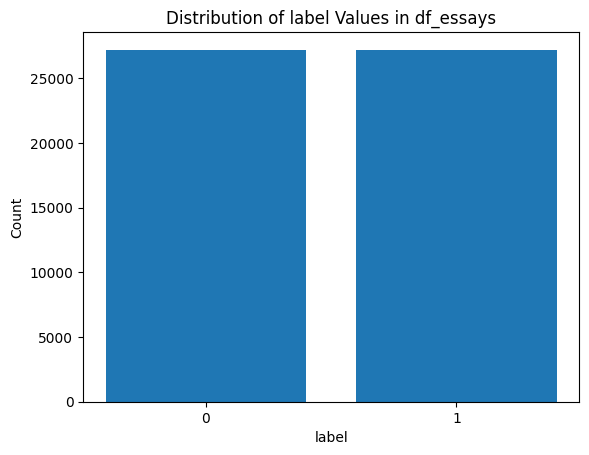

In [13]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def plot_label_distribution(df_essays, plots, task=None):
    
    if(plots == 1):
    # Calculate the count of label 1 in df_essays
        label_1_counts = df_essays[df_essays['label'] == 1].groupby('source').size()
        label_0_counts = df_essays[df_essays['label'] == 0].groupby('source').size()
        data=[
            go.Bar(name='Label 0', x=label_0_counts.index, y=label_0_counts.values),
            go.Bar(name='Label 1', x=label_1_counts.index, y=label_1_counts.values)
        ]
        # Create the bar chart using Plotly
        fig1 = go.Figure(data=data)

        # Update the layout
        fig1.update_layout(
            title='Counts of Label 0 and Label 1 per Source',
            xaxis_title='Source',
            yaxis_title='Count',
            barmode='group'
        )
        if(CFG.CLEARML_ON):          
            task.get_logger().report_plotly(title="Counts of Label 0 and Label 1 per Source", series="data", figure=fig1)
            
        # Show the chart using Plotly
        fig1.show()
        

    # Calculate the distribution of 'label' values in df_essays
    label_counts = df_essays['label'].value_counts().sort_index()

    # Print the label counts
    print("Label Counts:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count}")

    # Plot the distribution using Matplotlib
    plt.bar(['0', '1'], label_counts.values)
    plt.xlabel('label')
    plt.ylabel('Count')
    plt.title('Distribution of label Values in df_essays')
    plt.show()


plot_label_distribution(df_essays,1)

# Explain the code in the cell. Add this line to each cell
if(CFG.EXPLAIN_CODE):
    explain_code(_i)


### Clean Train Data

In [14]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def pipeline_preprocess_text(df):

    PUNCTUATION_TO_RETAIN = '.?!,'

    def preprocess_pipeline(text):
        try:
            # Remove markdown formatting
            html = markdown.markdown(text)
            text = BeautifulSoup(html, features="html.parser").get_text()
            # Replace newlines and remove extra whitespaces
            text = re.sub(r'[\n\r]+', ' ', text)
            text = ' '.join(text.split())
            # Remove 'Task' prefix from the prompt
            text = re.sub(r'^(?:Task(?:\s*\d+)?\.?\s*)?', '', text)
            text = re.sub('\n+', '', text)
            text = re.sub(r'[A-Z]+_[A-Z]+', '', text)
            # Remove punctuation except specified characters
            punctuation_to_remove = r'[^\w\s' + re.escape(PUNCTUATION_TO_RETAIN) + ']'
            text = re.sub(punctuation_to_remove, '', text)
            # Tokenize and lemmatize text
            tokens = word_tokenize(text)
            lemmatizer = WordNetLemmatizer()
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

            # Join tokens back to string
            return ' '.join(lemmatized_tokens)
        except Exception as e:
            logging.error(f"Error in preprocess_pipeline: {e}")
            return text

    # Apply the preprocessing pipeline to each text
    tqdm.pandas()
    start_time = time.time()
    df['text'] = df['text'].progress_apply(preprocess_pipeline)
    end_time = time.time()
    print(f"Preprocessing completed in {end_time - start_time:.2f} seconds")

    return df

#Usage
df_essays = pipeline_preprocess_text(df_essays)

if(CFG.CLEARML_ON):
    plot_label_distribution(df_essays, 0, task=clearml_handler.task)
    clearml_handler.task.upload_artifact(f'df_essays_train_preprocessed_{CFG.DATA_ETL_STRATEGY}', artifact_object=df_essays)
    clearml_handler.task.get_logger().report_table(title='df_essays_train_preprocessed_',series='Train Essays Cleaned',
                                                iteration=0,table_plot=df_essays)

# Explain the code in the cell. Add this line to each cell
if(CFG.EXPLAIN_CODE):
    explain_code(_i)


100%|██████████| 54400/54400 [10:12<00:00, 88.83it/s]

Preprocessing completed in 612.44 seconds


In [15]:
# Create a deep copy so i can use the original df_essays later
df_essays_copy = df_essays.copy(deep=True) ## for now


# Model Development
<img src="https://mikewlange.github.io/ai-or-human/images/aiorhuman_develop_model.drawio.png" alt="Alt Text" >


# 🤗 BERT-BiLSTM Classifier Model

<span style="display: inline-block;padding: 10px;background-color: #f4f3ee;border: 1px solid #FF1493;border-radius: 4px;margin-bottom: 10px;line-height: 1.5;color: #333;" class="tip">The BERT-BiLSTM Classifier model synergistically combines the BERT architecture with a Bidirectional Long Short-Term Memory (BiLSTM) network, enhancing the model's ability to understand context and sequence in text. This model integrates BERT's transformer layers with a BiLSTM network, a dropout layer for regularization, and a fully connected linear layer with ReLU activation, culminating in a linear classification layer.</span>

## Rationale

-   **BERT's Foundational Strength**: Utilizing the pre-trained BERT layers, the model leverages BERT's deep understanding of language semantics, gained from extensive training on diverse text corpora.
-   **Sequence and Context Awareness with BiLSTM**: The addition of BiLSTM layers enables the model to capture contextual information in both forward and backward directions, making it adept at understanding the sequence and flow of the text.
-   **Enhanced Text Processing Capabilities**: This architecture is particularly effective for complex classification tasks where understanding the context and sequence of words is crucial.

## Architecture

-   **Composition**: The model is composed of the BertModel layer followed by BiLSTM layers. This is further connected to a dropout layer for regularization, a fully connected linear layer with ReLU activation, and a final linear layer for classification.
-   **BiLSTM Configuration**: The BiLSTM layers are configured with customizable hidden sizes and layer counts, allowing the model to be adapted to different levels of sequence complexity.
-   **Loss and Optimization**: The model employs CrossEntropyLoss for loss computation and uses the AdamW optimizer. It focuses on optimizing metrics like accuracy and AUC, with an emphasis on balancing precision and recall.

## Adaptability and Use Cases

-   **Versatile for Various Text Data**: Given its enhanced contextual understanding, the BERT-BiLSTM Classifier is well-suited for tasks like sentiment analysis, topic classification, and other scenarios where the sequence of text plays a significant role.
-   **Customization and Flexibility**: The adjustable parameters of the BiLSTM layers (like hidden size and number of layers) offer flexibility, making the model adaptable to a wide range of text classification challenges.

In [16]:
if(CFG.CLEARML_ON):

    clearml_bert_sequence_classifier = ClearMLTaskHandler(
        project_name='LLM-detect-ai-gen-text-LIVE/dev/notebook/models/bert_sequence_classifier',
        task_name='Model Trainings',
    )
    clearml_bert_sequence_classifier.task.auto_connect_frameworks={
        'matplotlib': True, 'tensorflow': True, 'tensorboard': True, 'pytorch': True, 'scikit': True, 
        'hydra': True, 'detect_repository': True, 'joblib': True,
    }


In [17]:
# Required Imports
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import pandas as pd
import logging
import optuna
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
model_config = {
    'bert_model_name': CFG.BERT_MODEL,
    'num_classes': 2,
    'max_length': 128,
    'batch_size': 16,
    'num_epochs': 6,
    'train_data': df_essays_copy,
    'num_trials': 2,
}
#clearml_bertmodel_custom.task.connect(model_config)
# Load data function
def load_data():
    texts = model_config['train_data']['text'].str.lower().tolist()  # Lowercase for uncased BERT
    labels = model_config['train_data']['label'].tolist()
    return texts, labels


class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt').to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item


class BERTBiLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_rate=0.1, lstm_hidden_size=128, lstm_layers=2):
        super(BERTBiLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, lstm_hidden_size, lstm_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)  # *2 for bidirectional
        self.relu = nn.ReLU()  # ReLU activation layer

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, (h_n, c_n) = self.lstm(sequence_output)
        pooled_output = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)
        x = self.dropout(pooled_output)
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc(x)
        return x



texts, labels = load_data()
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

tokenizer = BertTokenizer.from_pretrained(model_config['bert_model_name'])
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, model_config['max_length'])
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, model_config['max_length'])
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, model_config['max_length'])

train_dataloader = DataLoader(train_dataset, batch_size=model_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=model_config['batch_size'])
test_dataloader = DataLoader(test_dataset, batch_size=model_config['batch_size'])


run_name = f"run_{int(time.time())}"
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
writer = SummaryWriter(log_dir=f'{CFG.SCRATCH_PATH}/logs/bertmodel_custom/{run_name}')


def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    total_loss = 0
    leng = len(data_loader)
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        avg_loss = total_loss / leng
        #logger.info(f"Epoch {epoch} - Training loss: {avg_loss}")
        writer.add_scalar('Training Loss', avg_loss, epoch)

def evaluate(model, data_loader, device, epoch, phase='Validation'):

    model.eval()
    predictions = []
    actual_labels = []

    _labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=1)
    recall = recall_score(actual_labels, predictions, average='binary')
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=1)
    auc = roc_auc_score(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)

    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'{phase} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{phase}_confusion_matrix_epoch_{epoch}.png')
    plt.close()

    #logger.info(f"Epoch {epoch} - {phase} Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    writer.add_scalar(f'{phase} Accuracy', accuracy, epoch)
    writer.add_scalar(f'{phase} Precision', precision, epoch)
    writer.add_scalar(f'{phase} Recall', recall, epoch)
    writer.add_scalar(f'{phase} F1 Score', f1, epoch)

    return accuracy, precision, recall, f1, auc, classification_report(actual_labels, predictions)


# Optuna Hyperparameter Optimization
def objective(trial):
    # Suggest hyperparameters for training
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_int('batch_size', 16, 32)
    # Suggest hyperparameters for model architecture
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.1)
    fc_layer_size = trial.suggest_categorical('fc_layer_size', [64, 128])


    lstm_hidden_size = trial.suggest_categorical('lstm_hidden_size', [64, 128])# =128,
    lstm_layers=trial.suggest_int('lstm_layers', 2, 4)


    #model = BERTBiLSTMClassifier(model_config['bert_model_name'],model_config['num_classes'],dropout_rate,lstm_hidden_size )
    model = BERTBiLSTMClassifier(model_config['bert_model_name'], model_config['num_classes'], dropout_rate, fc_layer_size,lstm_layers)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    #total_steps = len(train_dataloader) / model_config['num_epochs'] / model_config['batch_size']
    total_steps = len(train_dataloader) * model_config['num_epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_auc = 0
    for epoch in tqdm(range(model_config['num_epochs']), desc='Epoch'):
        train(model, train_dataloader, optimizer, scheduler, device, epoch)
        accuracy, precision, recall, f1, auc, report = evaluate(model, val_dataloader, device, epoch)

        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"precision: {precision:.4f}")
        print(f"recall: {recall:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"auc: {auc:.4f}")
        print(report)

        if auc > best_val_auc:
            best_val_auc = auc
            best_params = {
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'fc_layer_size': fc_layer_size
            }
            torch.save(model.state_dict(), f"{CFG.SCRATCH_PATH}/bert_finetune_custom_{trial.number}.pt")

    torch.save(best_params, f"{CFG.SCRATCH_PATH}/best_trial_params.json")
    return best_val_auc

# Create a study object and optimize the objective function
bert_best_custom_study = optuna.create_study(direction='maximize', study_name='bert_best_custom_study')
bert_best_custom_study.optimize(objective, n_trials=model_config['num_trials'])

# Retrain model with best hyperparameters
best_trial = bert_best_custom_study.best_trial

#Load the model with the best trial
best_trial_params = bert_best_custom_study.best_trial.params
learning_rate = best_trial_params["learning_rate"]
dropout_rate = best_trial_params["dropout_rate"]
fc_layer_size = best_trial_params["fc_layer_size"]
lstm_hidden_size = best_trial_params["lstm_hidden_size"]
lstm_layers = best_trial_params["lstm_layers"]

# Pickle the tokenizer, study, and best model
with open(f'{CFG.SCRATCH_PATH}/custom_bert_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open(f'{CFG.SCRATCH_PATH}/best_custom_model_study.pkl', 'wb') as f:
    pickle.dump(bert_best_custom_study, f)


#Initialize the best model with the optimal hyperparameters

best_model = BERTBiLSTMClassifier(model_config['bert_model_name'], model_config['num_classes'], dropout_rate, fc_layer_size,lstm_layers)

best_model.to(device)

#Set up optimizer and scheduler for the best model
optimizer = torch.optim.AdamW(best_model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * model_config['num_epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Retrain the model with the best hyperparameters
for epoch in tqdm(range(model_config['num_epochs']), desc='Epoch'):
    train(best_model, train_dataloader, optimizer, scheduler, device, epoch)
    evaluate(best_model, val_dataloader, device, epoch)

#Save the retrained best model
torch.save(best_model.state_dict(), f"{CFG.SCRATCH_PATH}/bert_bilstm_model.pt")

# For ClearML Model Registration
# torch.jit.script(best_model).save('bert_bilstm_model.pt')
# OutputModel().update_weights('bert_bilstm_model.pt')
#torch.save(best_model.state_dict(), 'bert_bilstm_model.pt')
#output_model = OutputModel(task=clearml_bertmodel_custom.task)
#output_model.update_weights(f"{CFG.SCRATCH_PATH}/bert_bilstm_model.pt")

#Print best trial details
print("Best trial:")
print(f" Value: {best_trial.value:.4f}")
print(" Params: ")
for key, value in best_trial.params.items():
    print(f" {key}: {value}")


[I 2024-01-21 00:39:57,401] A new study created in memory with name: bert_best_custom_study
Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation Accuracy: 0.9723
precision: 0.9492
recall: 0.9983
F1: 0.9731
auc: 0.9722
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4063
           1       0.95      1.00      0.97      4097

    accuracy                           0.97      8160
   macro avg       0.97      0.97      0.97      8160
weighted avg       0.97      0.97      0.97      8160



Epoch:  17%|█▋        | 1/6 [16:19<1:21:37, 979.46s/it]

Validation Accuracy: 0.9923
precision: 0.9881
recall: 0.9966
F1: 0.9923
auc: 0.9923
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  50%|█████     | 3/6 [49:24<49:28, 989.46s/it]  

Validation Accuracy: 0.9892
precision: 0.9806
recall: 0.9983
F1: 0.9894
auc: 0.9892
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4063
           1       0.98      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160

Validation Accuracy: 0.9950
precision: 0.9932
recall: 0.9968
F1: 0.9950
auc: 0.9950
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      1.00      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  83%|████████▎ | 5/6 [1:22:29<16:31, 991.25s/it]

Validation Accuracy: 0.9936
precision: 0.9901
recall: 0.9973
F1: 0.9937
auc: 0.9936
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch: 100%|██████████| 6/6 [1:39:00<00:00, 990.03s/it]
[I 2024-01-21 02:19:03,992] Trial 0 finished with value: 0.9949677435167891 and parameters: {'learning_rate': 2.9665565111091976e-05, 'batch_size': 16, 'dropout_rate': 0.07441494793429966, 'fc_layer_size': 128, 'lstm_hidden_size': 128, 'lstm_layers': 2}. Best is trial 0 with value: 0.9949677435167891.


Validation Accuracy: 0.9923
precision: 0.9870
recall: 0.9978
F1: 0.9924
auc: 0.9923
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation Accuracy: 0.9880
precision: 0.9805
recall: 0.9959
F1: 0.9881
auc: 0.9880
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4063
           1       0.98      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  17%|█▋        | 1/6 [16:22<1:21:52, 982.60s/it]

Validation Accuracy: 0.9919
precision: 0.9934
recall: 0.9905
F1: 0.9919
auc: 0.9919
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4063
           1       0.99      0.99      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  33%|███▎      | 2/6 [32:45<1:05:31, 982.92s/it]

Validation Accuracy: 0.9925
precision: 0.9917
recall: 0.9934
F1: 0.9926
auc: 0.9925
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4063
           1       0.99      0.99      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  50%|█████     | 3/6 [49:08<49:08, 982.75s/it]  

Validation Accuracy: 0.9928
precision: 0.9884
recall: 0.9973
F1: 0.9928
auc: 0.9928
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch:  67%|██████▋   | 4/6 [1:05:30<32:45, 982.73s/it]

Validation Accuracy: 0.9951
precision: 0.9954
recall: 0.9949
F1: 0.9951
auc: 0.9951
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4063
           1       1.00      0.99      1.00      4097

    accuracy                           1.00      8160
   macro avg       1.00      1.00      1.00      8160
weighted avg       1.00      1.00      1.00      8160



Epoch: 100%|██████████| 6/6 [1:38:16<00:00, 982.74s/it]
[I 2024-01-21 03:57:21,318] Trial 1 finished with value: 0.9950989753702831 and parameters: {'learning_rate': 2.7173365666001045e-05, 'batch_size': 30, 'dropout_rate': 0.07579404291543629, 'fc_layer_size': 64, 'lstm_hidden_size': 128, 'lstm_layers': 2}. Best is trial 1 with value: 0.9950989753702831.


Validation Accuracy: 0.9924
precision: 0.9870
recall: 0.9980
F1: 0.9925
auc: 0.9924
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4063
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      8160
   macro avg       0.99      0.99      0.99      8160
weighted avg       0.99      0.99      0.99      8160



Epoch: 100%|██████████| 6/6 [1:38:11<00:00, 981.97s/it]


Best trial:
 Value: 0.9951
 Params: 
 learning_rate: 2.7173365666001045e-05
 batch_size: 30
 dropout_rate: 0.07579404291543629
 fc_layer_size: 64
 lstm_hidden_size: 128
 lstm_layers: 2


# Inference Pipeline
<img src="https://mikewlange.github.io/ai-or-human/images/aiorhuman_inference.drawio.png" width='1000px' alt="Inference Pipeline" >

## Load Essays for Inference 

In [18]:
from torch.nn.functional import softmax

if(CFG.KAGGLE_RUN == True):
    essays_for_inference_final = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
else:
# OR LOAD THE CONTEST SUBMISSION DATA 
        # Get the holdoutdata from traiing. and all the train_essays from the Kaggle competition as out-of-sample data
    essays_for_inference = pd.read_pickle('/kaggle/working/df_essays_holdout_1.pkl') # Bulk holdout data from training set 
    essays_for_inference_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv') # Kaggle competition data that we did not use in your training set

    essays_for_inference_train['source'] = 'kaggle-competition'
    # Sample Holdout to a couple g's for testing, 
    essays_for_inference_1 = essays_for_inference[essays_for_inference['label'] == 1].sample(len(essays_for_inference_train))
    #essays_for_inference_0 = essays_for_inference[essays_for_inference['label'] == 0].sample(len(essays_for_inference_train))
    essays_for_inference_0 = essays_for_inference_train[essays_for_inference_train['generated'] == 0]
    # rename essays_for_inference_0.column.generated
    essays_for_inference_0.rename(columns={'generated':'label'}, inplace=True)

    essays_for_inference_cntat = pd.concat([essays_for_inference_1, essays_for_inference_0])
    # shuffle essays_for_inference_cntat
    essays_for_inference_final = essays_for_inference_cntat.sample(frac=1).reset_index(drop=True)



In [19]:
df_to_classify = pipeline_preprocess_text(essays_for_inference_final)


100%|██████████| 3/3 [00:00<00:00, 353.92it/s]

Preprocessing completed in 0.01 seconds


# Inference Function BERT

In [20]:
import torch
import pandas as pd


def bert_inference(dataframe, model, tokenizer, max_length, device):
    """
    Performs inference on a dataframe using a pre-loaded model and returns softmax probabilities.

    Args:
    - dataframe (pd.DataFrame): DataFrame containing the texts to classify.
    - model (torch.nn.Module): Pre-loaded trained model for inference.
    - tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the model.
    - max_length (int): Maximum sequence length for tokenization.
    - device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    - pd.DataFrame: Original DataFrame with additional columns for predictions and probabilities.
    """
    model.to(device)
    model.eval()

    predictions = []
    probabilities = []

    for _, row in dataframe.iterrows():
        text = row['text']

        # Tokenize the text
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask)

            # Check if output has 'logits' attribute
            logits = output.logits if hasattr(output, 'logits') else output

            probs = torch.nn.functional.softmax(logits, dim=1)
            probabilities_ind = torch.nn.functional.softmax(probs, dim=1).cpu().numpy()[0]

            # probs = softmax(logits, dim=1)
            prediction = torch.argmax(probs, dim=1).cpu().numpy()[0]
            # if the prediction is 0 get the softmax min value otherwise get the max value
            if (prediction>= 1):
                # Get the minimum value of the softmax probabilities
                probability = max(probabilities_ind)
            else:
                probability = min(probabilities_ind)

            predictions.append(prediction)
            probabilities.append(probability)

    dataframe['predicted_label'] = predictions
    dataframe['probability'] = probabilities
    return dataframe


In [21]:
model_config = {
    'bert_model_name': CFG.BERT_MODEL,
    'num_classes': 2,
    'max_length': 128,
    'batch_size': 16,
    'num_epochs': 4,
    'train_data': df_essays_copy,
    'num_trials': 2,
}



# Pickle the tokenizer, study, and best model
with open(f'{CFG.SCRATCH_PATH}/custom_bert_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

with open(f'{CFG.SCRATCH_PATH}/best_custom_model_study.pkl', 'rb') as f:
    study = pickle.load(f)


    # Retrain model with best hyperparameters
best_trial = study.best_trial

#Load the model with the best trial
best_trial_params = study.best_trial.params
learning_rate = best_trial_params["learning_rate"]
dropout_rate = best_trial_params["dropout_rate"]
fc_layer_size = best_trial_params["fc_layer_size"]
lstm_hidden_size = best_trial_params["lstm_hidden_size"]
lstm_layers = best_trial_params["lstm_layers"]

best_model = BERTBiLSTMClassifier(model_config['bert_model_name'], model_config['num_classes'], dropout_rate, fc_layer_size,lstm_layers)
best_model.load_state_dict(torch.load(f"{CFG.SCRATCH_PATH}/bert_bilstm_model.pt",map_location=device))
#Initialize the best model with the optimal hyperparameters
best_model.to(device)

print(best_model)
custom_bert_inference_results = bert_inference(df_to_classify, best_model, tokenizer, model_config['max_length'], device)

if(CFG.KAGGLE_RUN == False):
    ## STATISTICS
    #Calculate the number of correct predictions
    correct_predictions = (custom_bert_inference_results['label'] == custom_bert_inference_results['predicted_label']).sum()
    # Calculate the total number of predictions
    total_predictions = len(custom_bert_inference_results)

    # Calculate the accuracy
    accuracy = correct_predictions / total_predictions

    # Print the statistics
    print(f"Total predictions: {total_predictions}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")

    # Get the true labels and predicted labels as numpy arrays
    true_labels = custom_bert_inference_results['label'].to_numpy()
    predicted_labels = custom_bert_inference_results['predicted_label'].to_numpy()

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    if(CFG.CLEARML_ON):
        clearml_bertmodel_custom.log_data(data=cm,title='Custom Bert Classifier Inference Results Confusoon Matric')
    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    incorrect_row_numbers = np.where(true_labels != predicted_labels)[0]

    # Print the row numbers of incorrect predictions
    print("Incorrect Row Numbers:")
    print(incorrect_row_numbers)

BERTBiLSTMClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

# Submission

In [22]:
# Create a DataFrame to store the submission
#essays_for_inference_final = pd.read_csv('/Users/lange/dev/ai-or-biology/scratch/test_essays.csv')
#if(CFG.KAGGLE_RUN == True):
sub_df = essays_for_inference_final[["id"]].copy()

# Add the formatted predictions to the submission DataFrame

sub_df["generated"] = custom_bert_inference_results['probability']

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()


,id,generated
0,0000aaaa,0.728805
1,1111bbbb,0.727913
2,2222cccc,0.722915
